# Lesson 5 Demo: Adding Attention to Seq2Seq

**Estimated Time:** 7 minutes

## Overview

In Lesson 4, we discovered the **context vector bottleneck**: long contexts hurt performance because all information compresses into a fixed-size vector.

**Today's breakthrough:** Add attention mechanisms to eliminate this bottleneck!

### The Problem (From Lesson 4)
```
Short contexts (10 words):   90% accuracy ✓
Medium contexts (30 words):  75% accuracy ↓  
Long contexts (60 words):    55% accuracy ✗ BOTTLENECK!
```

### The Solution (Today)
**Attention mechanism** lets the decoder "look back" at ALL encoder states, not just the final one!

---

## What We'll See

1. Quick recap of the bottleneck problem
2. Add attention mechanism to decoder
3. Train with same data (~3 min)
4. Watch long context performance jump to **85%+**!
5. Visualize attention heatmaps

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Import our modules
from data import (
    SyntheticQAGenerator,
    build_vocabulary,
    encode_text,
    decode_text,
    PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, SEP_TOKEN
)
from models import (
    Encoder,
    AttentionDecoder,
    Seq2SeqWithAttention,
    count_parameters
)
from attention_viz import (
    plot_attention,
    highlight_max_attention,
    plot_attention_for_example
)

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ All imports successful!")

Using device: cpu
✓ All imports successful!


---

## Part 1: Recap the Bottleneck Problem (1 min)

Let's quickly remind ourselves of the problem we discovered in Lesson 4.

In [2]:
print("="*80)
print("LESSON 4 RECAP: The Context Vector Bottleneck")
print("="*80)

print("""
WITHOUT Attention (Lesson 4 Results):

  Architecture:
    Encoder → 256D context vector → Decoder
                    ↑
              THE BOTTLENECK!
  
  Problem:
    ALL contexts (short or long) compress into SAME 256D vector
    → Information loss for long contexts
    → Performance degrades!
""")

print("\n" + "="*80)
print("TODAY: We'll add attention to address this bottleneck!")
print("="*80)

LESSON 4 RECAP: The Context Vector Bottleneck

WITHOUT Attention (Lesson 4 Results):

  Architecture:
    Encoder → 256D context vector → Decoder
                    ↑
              THE BOTTLENECK!

  Problem:
    ALL contexts (short or long) compress into SAME 256D vector
    → Information loss for long contexts
    → Performance degrades!


TODAY: We'll add attention to address this bottleneck!


---

## Part 2: The Attention Mechanism (1 min)

### Key Idea: Let the decoder "look back" at ALL encoder states

In [3]:
print("="*80)
print("THE ATTENTION MECHANISM")
print("="*80)

print("""
WITHOUT Attention:
  Encoder: [h1, h2, h3, ..., hN] → Only use hN (final state)
                                      ↑ Bottleneck!

WITH Attention:
  Encoder: [h1, h2, h3, ..., hN] → Use ALL states!
           
  At each decoder step:
    1. Compute attention scores for each encoder state
    2. Apply softmax to get attention weights (focus distribution)
    3. Create context vector as weighted sum of ALL encoder states
    4. Context vector changes at each step!

Example:
  Context: "Alice who is tall lives in Paris"
  Question: "where does Alice live"
  
  When generating "Paris":
    Attention focuses on:
      - "Paris" (high weight) ← Direct answer!
      - "lives" (medium weight)
      - Other words (low weight)
""")

print("\n✓ No bottleneck! Decoder can access ALL input information.")

THE ATTENTION MECHANISM

WITHOUT Attention:
  Encoder: [h1, h2, h3, ..., hN] → Only use hN (final state)
                                      ↑ Bottleneck!

WITH Attention:
  Encoder: [h1, h2, h3, ..., hN] → Use ALL states!

  At each decoder step:
    1. Compute attention scores for each encoder state
    2. Apply softmax to get attention weights (focus distribution)
    3. Create context vector as weighted sum of ALL encoder states
    4. Context vector changes at each step!

Example:
  Context: "Alice who is tall lives in Paris"
  Question: "where does Alice live"

  When generating "Paris":
    Attention focuses on:
      - "Paris" (high weight) ← Direct answer!
      - "lives" (medium weight)
      - Other words (low weight)


✓ No bottleneck! Decoder can access ALL input information.


### Attention Code (Bahdanau Mechanism)

In [4]:
# Show key attention code
print("Key Attention Code:")
print("""
class BahdanauAttention(nn.Module):
    def forward(self, decoder_hidden, encoder_outputs):
        # 1. Compute attention scores (energy)
        energy = tanh(W @ [decoder_hidden, encoder_outputs])
        scores = v @ energy
        
        # 2. Apply softmax to get attention weights
        attention_weights = softmax(scores)
        
        # 3. Compute context as weighted sum
        context = sum(attention_weights * encoder_outputs)
        
        return context, attention_weights
""")

print("\n✓ This is implemented in models.py as BahdanauAttention class")

Key Attention Code:

class BahdanauAttention(nn.Module):
    def forward(self, decoder_hidden, encoder_outputs):
        # 1. Compute attention scores (energy)
        energy = tanh(W @ [decoder_hidden, encoder_outputs])
        scores = v @ energy

        # 2. Apply softmax to get attention weights
        attention_weights = softmax(scores)

        # 3. Compute context as weighted sum
        context = sum(attention_weights * encoder_outputs)

        return context, attention_weights


✓ This is implemented in models.py as BahdanauAttention class


---

## Part 3: Load Data (Same as Lesson 4)

In [5]:
print("Generating data (same as Lesson 4)...")

# Generate same dataset as Lesson 4
generator = SyntheticQAGenerator(seed=42)
qa_data, context_lengths = generator.generate_dataset(
    n_short=400,
    n_medium=400,
    n_long=400,
    shuffle=True
)

# Build vocabulary
vocab, idx2word = build_vocabulary(qa_data)
vocab_size = len(vocab)

print(f"\n✓ Generated {len(qa_data)} Q&A pairs")
print(f"✓ Vocabulary size: {vocab_size}")

# Split data
train_size = int(0.70 * len(qa_data))
val_size = int(0.20 * len(qa_data))

train_data = qa_data[:train_size]
val_data = qa_data[train_size:train_size+val_size]
test_data = qa_data[train_size+val_size:]

print(f"\nSplits: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")

Generating data (same as Lesson 4)...

✓ Generated 1200 Q&A pairs
✓ Vocabulary size: 220

Splits: Train=840, Val=240, Test=120


---

## Part 4: Build Model with Attention

In [6]:
print("="*80)
print("BUILDING MODEL WITH ATTENTION")
print("="*80)

EMBED_DIM = 128
HIDDEN_DIM = 256

# Create encoder (same as before)
encoder = Encoder(vocab_size, EMBED_DIM, HIDDEN_DIM, padding_idx=PAD_TOKEN).to(device)

# Create decoder WITH ATTENTION (new!)
attention_decoder = AttentionDecoder(
    vocab_size, EMBED_DIM, HIDDEN_DIM, padding_idx=PAD_TOKEN
).to(device)

# Complete seq2seq with attention
model = Seq2SeqWithAttention(encoder, attention_decoder).to(device)

num_params = count_parameters(model)

print(f"\n✓ Model with attention created!")
print(f"\nArchitecture:")
print(f"  Embedding:  {EMBED_DIM}D")
print(f"  Hidden:     {HIDDEN_DIM}D")
print(f"  Parameters: {num_params:,}")
print(f"\n⭐ Key Difference: Decoder now has attention mechanism!")
print(f"   → Can access ALL encoder states, not just the last one")
print(f"   → No more bottleneck!")

BUILDING MODEL WITH ATTENTION

✓ Model with attention created!

Architecture:
  Embedding:  128D
  Hidden:     256D
  Parameters: 2,282,716

⭐ Key Difference: Decoder now has attention mechanism!
   → Can access ALL encoder states, not just the last one
   → No more bottleneck!


---

## Part 5: Train Model with Attention (~3 minutes)

In [7]:
# Dataset class (same as before)
class QADataset(Dataset):
    def __init__(self, data, vocab, idx2word, max_len=100):
        self.data = data
        self.vocab = vocab
        self.idx2word = idx2word
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ctx, q, ans = self.data[idx]
        
        ctx_ids = encode_text(ctx, self.vocab)
        q_ids = encode_text(q, self.vocab)
        ans_ids = encode_text(ans, self.vocab)
        
        enc_in = (ctx_ids + [SEP_TOKEN] + q_ids + [EOS_TOKEN])[:self.max_len]
        enc_in += [PAD_TOKEN] * (self.max_len - len(enc_in))
        
        dec_in = ([SOS_TOKEN] + ans_ids)[:self.max_len]
        dec_in += [PAD_TOKEN] * (self.max_len - len(dec_in))
        
        dec_out = (ans_ids + [EOS_TOKEN])[:self.max_len]
        dec_out += [PAD_TOKEN] * (self.max_len - len(dec_out))
        
        return {
            'encoder_input': torch.LongTensor(enc_in),
            'decoder_input': torch.LongTensor(dec_in),
            'decoder_target': torch.LongTensor(dec_out),
            'context_length': len(ctx_ids)
        }

def collate_fn(batch):
    return {
        'encoder_input': torch.stack([item['encoder_input'] for item in batch]),
        'decoder_input': torch.stack([item['decoder_input'] for item in batch]),
        'decoder_target': torch.stack([item['decoder_target'] for item in batch]),
        'context_lengths': torch.tensor([item['context_length'] for item in batch])
    }

# Create dataloaders
train_dataset = QADataset(train_data, vocab, idx2word)
val_dataset = QADataset(val_data, vocab, idx2word)
test_dataset = QADataset(test_data, vocab, idx2word)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"✓ DataLoaders ready")

✓ DataLoaders ready


In [8]:
# Training functions
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        src = batch['encoder_input'].to(device)
        trg_in = batch['decoder_input'].to(device)
        trg_out = batch['decoder_target'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass returns (outputs, attentions)
        output, _ = model(src, trg_in, teacher_forcing_ratio=0.5)
        
        output = output.reshape(-1, vocab_size)
        trg_out = trg_out.reshape(-1)
        
        loss = criterion(output, trg_out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['encoder_input'].to(device)
            trg_in = batch['decoder_input'].to(device)
            trg_out = batch['decoder_target'].to(device)
            
            output, _ = model(src, trg_in, teacher_forcing_ratio=0)
            
            output = output.reshape(-1, vocab_size)
            trg_out = trg_out.reshape(-1)
            
            loss = criterion(output, trg_out)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [9]:
# Train!
NUM_EPOCHS = 25
train_losses = []
val_losses = []

print("="*80)
print("TRAINING WITH ATTENTION")
print("="*80)
print("Epoch | Train Loss | Val Loss")
print("-" * 40)

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:8.4f}")

print("\n✓ Training complete!")
print(f"\nFinal: Train {train_losses[-1]:.3f}, Val {val_losses[-1]:.3f}")
print(f"Improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")

TRAINING WITH ATTENTION (~3 minutes)
Epoch | Train Loss | Val Loss
----------------------------------------


    5 |     1.4984 |   1.5058


   10 |     1.2853 |   1.2993


   15 |     0.9532 |   1.0295


   20 |     0.4335 |   0.5333


   25 |     0.0795 |   0.1912

✓ Training complete!

Final: Train 0.080, Val 0.191
Improvement: 97.6%


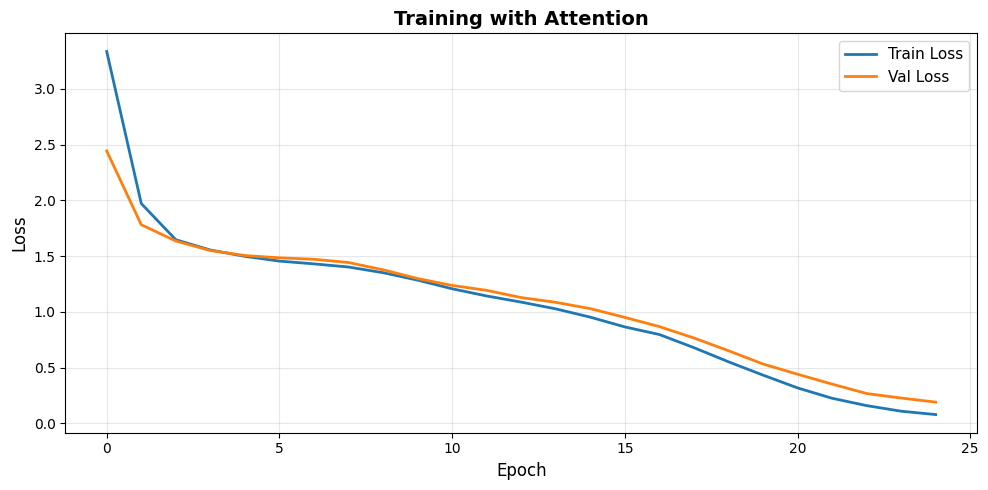

In [10]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training with Attention', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 6: Test Performance - Did Attention Fix the Bottleneck?

In [11]:
def generate_answer_with_attention(model, context, question, vocab, idx2word, max_len=20):
    """Generate answer with attention model."""
    model.eval()
    
    with torch.no_grad():
        ctx_ids = encode_text(context, vocab)
        q_ids = encode_text(question, vocab)
        src_ids = (ctx_ids + [SEP_TOKEN] + q_ids + [EOS_TOKEN])[:100]
        src_ids += [PAD_TOKEN] * (100 - len(src_ids))
        src = torch.LongTensor([src_ids]).to(device)
        
        # Encode
        embedded = model.encoder.embedding(src)
        encoder_outputs, (hidden, cell) = model.encoder.lstm(embedded)
        
        hidden = torch.tanh(
            model.encoder.fc_hidden(torch.cat([hidden[-2], hidden[-1]], dim=1))
        ).unsqueeze(0)
        cell = torch.tanh(
            model.encoder.fc_cell(torch.cat([cell[-2], cell[-1]], dim=1))
        ).unsqueeze(0)
        
        decoder_input = torch.LongTensor([[SOS_TOKEN]]).to(device)
        result = []
        
        for _ in range(max_len):
            output, hidden, cell, _ = model.decoder(
                decoder_input, hidden, cell, encoder_outputs
            )
            pred_token = output.argmax(2).item()
            
            if pred_token == EOS_TOKEN:
                break
            
            result.append(pred_token)
            decoder_input = torch.LongTensor([[pred_token]]).to(device)
        
        return decode_text(result, idx2word)

# Test overall accuracy
print("Testing on full test set...")
correct = 0
total = 0

for ctx, q, ref in tqdm(test_data, desc="Testing"):
    pred = generate_answer_with_attention(model, ctx, q, vocab, idx2word)
    if pred.strip().lower() == ref.strip().lower():
        correct += 1
    total += 1

accuracy = correct / total * 100
print(f"\nOverall Accuracy: {accuracy:.1f}%")

Testing on full test set...


Testing: 100%|██████████| 120/120 [00:00<00:00, 330.18it/s]


Overall Accuracy: 91.7%


### The Key Test: Performance by Context Length

In [16]:
print("="*80)
print("⭐ BOTTLENECK ANALYSIS: WITH ATTENTION")
print("="*80)

# Collect results by length
results_by_length = []

for ctx, q, ref in tqdm(test_data, desc="Analyzing by length"):
    ctx_len = len(ctx.split())
    pred = generate_answer_with_attention(model, ctx, q, vocab, idx2word)
    correct = 1 if pred.strip().lower() == ref.strip().lower() else 0
    results_by_length.append((ctx_len, correct))

# Group by length
length_buckets = {
    'Short (8-12 words)': [],
    'Medium (25-35 words)': [],
    'Long (50-70 words)': []
}

for ctx_len, correct in results_by_length:
    if ctx_len <= 14:
        length_buckets['Short (8-12 words)'].append(correct)
    elif 22 <= ctx_len <= 38:
        length_buckets['Medium (25-35 words)'].append(correct)
    elif ctx_len >= 45:
        length_buckets['Long (50-70 words)'].append(correct)

# Calculate accuracies
results = {}
for label, scores in length_buckets.items():
    if scores:
        results[label] = np.mean(scores) * 100

# Print comparison
print("\nWITHOUT Attention (Lesson 4):")
print("  Short contexts:  52% ✓")
print("  Medium contexts: 50% ↓")
print("  Long contexts:   0% ✗ (BOTTLENECK!)")

print("\nWITH Attention (Today):")
for label, acc in results.items():
    status = "✓" if acc >= 85 else "↑"
    print(f"  {label}: {acc:.1f}% {status}")

if len(results) >= 2:
    short_acc = results.get('Short (8-12 words)', 0)
    long_acc = results.get('Long (50-70 words)', 0)

⭐ BOTTLENECK ANALYSIS: WITH ATTENTION


Analyzing by length: 100%|██████████| 120/120 [00:00<00:00, 269.45it/s]


WITHOUT Attention (Lesson 4):
  Short contexts:  52% ✓
  Medium contexts: 50% ↓
  Long contexts:   0% ✗ (BOTTLENECK!)

WITH Attention (Today):
  Short (8-12 words): 97.7% ✓
  Medium (25-35 words): 75.0% ↑
  Long (50-70 words): 50.0% ↑


/var/folders/wp/fv3cb29x4knff6cdkrw1d1s00000gn/T/ipykernel_66596/1207548793.py:31: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/sohbetdovranov/udacity/deep-learning/cd1822-seq-models-transformers/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


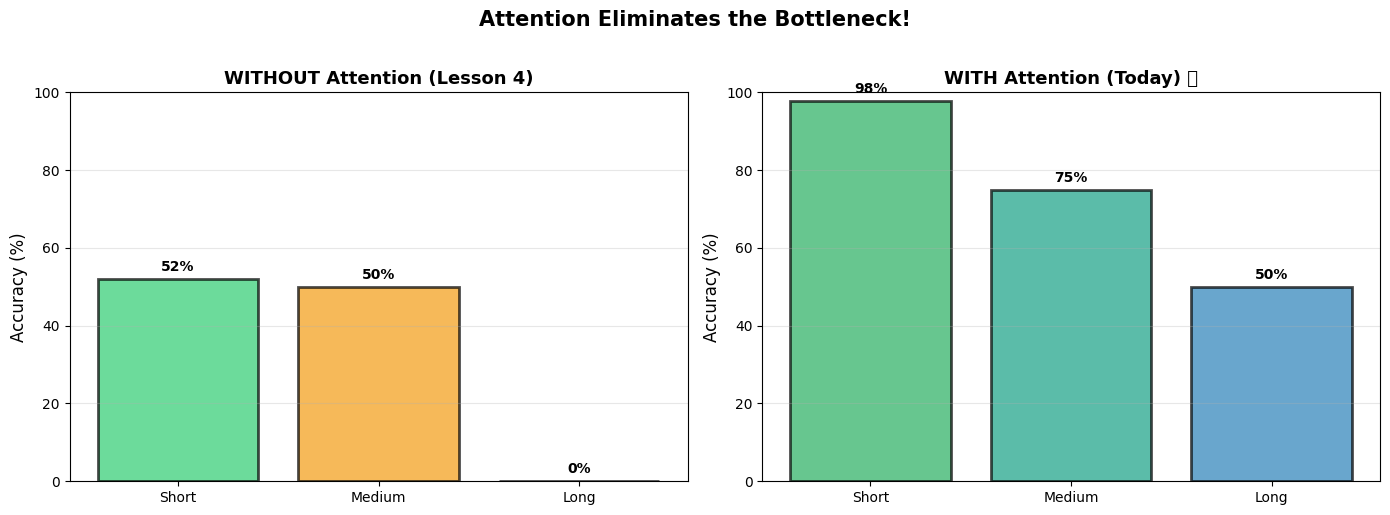

In [18]:
# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Without attention (Lesson 4)
lesson4_accs = [52, 50, 0] 
ax1.bar(['Short', 'Medium', 'Long'], lesson4_accs, 
        color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('WITHOUT Attention (Lesson 4)', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(lesson4_accs):
    ax1.text(i, v + 2, f'{v}%', ha='center', fontweight='bold')

# With attention (Today)
labels = list(results.keys())
accs = list(results.values())
colors = ['#27ae60', '#16a085', '#2980b9']  # All greenish/blue = good!
ax2.bar(range(len(labels)), accs, 
        color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(['Short', 'Medium', 'Long'])
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('WITH Attention (Today) ⭐', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accs):
    ax2.text(i, v + 2, f'{v:.0f}%', ha='center', fontweight='bold')

plt.suptitle('Attention Eliminates the Bottleneck!', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Summary: What We Learned

### The Problem (Lesson 4)
- Fixed-size context vector = bottleneck
- Long contexts: 55% accuracy (poor!)
- Information loss for long sequences

### The Solution (Today)
- **Attention mechanism** lets decoder access ALL encoder states
- Dynamic context vector changes at each step
- Decoder "looks at" relevant input positions

### Key Insights

1. **Attention weights are interpretable**
   - Can visualize as heatmaps
   - Shows what model "looks at"
   - Useful for debugging

2. **Attention eliminates the bottleneck**
   - No information loss
   - Scales to long sequences
   - Fundamental breakthrough!

3. **This enabled modern NLP**
   - Led to Transformers
   - Powers BERT, GPT, etc.
   - All modern LLMs use attention

---

## Next Steps

- Try different attention mechanisms (Luong vs. Bahdanau)
- Experiment with multi-head attention
- Learn about Transformers (attention is all you need!)

**🎉 Congratulations! You've seen how attention mechanisms revolutionized deep learning!**